In [36]:
## Importing required packages
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage, BaseMessage
from typing import TypedDict, Annotated, Literal

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_perplexity import ChatPerplexity
from dotenv import load_dotenv

from pydantic import BaseModel, Field
from langgraph.graph import add_messages
import operator

import os

## Libraries to retain memory
from langgraph.checkpoint.memory import MemorySaver

In [23]:
## Initiating the environment
load_dotenv()

## Defining and initiating llm
model = ChatPerplexity(model= 'sonar', api_key= os.getenv("PERPLEXITY_API_KEY"))

In [24]:
## Defining the state that needs to be passed while invoking the model
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [25]:
## Function that iterates and improves the Tweet
def chat_node(state: ChatState) -> ChatState:
    ## Take a user query from the state
    message = state['messages']

    ## Send to LLM
    response = model.invoke(message)

    ## Response store state
    return {'messages' : [response]}

In [37]:
## Define the checkpointer to retain memory
checkpointer = MemorySaver()

## Define the graph
graph = StateGraph(ChatState)

## Add node
graph.add_node('chat_node', chat_node)

## Add edges
graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

## Conpile the graph
workflow = graph.compile(checkpointer = checkpointer)

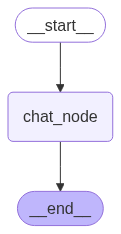

In [38]:
## Visualize the graph
workflow

In [28]:
## Invoking the graph
initial_state = {'messages' : 'Who discovered xAI ?'}
final_state = workflow.invoke(initial_state)
print(final_state)

{'messages': [HumanMessage(content='Who discovered xAI ?', additional_kwargs={}, response_metadata={}, id='f5f95fd6-db93-413c-8a80-de4c6b6c2e1b'), AIMessage(content='**xAI was discovered (founded) by Elon Musk in March 2023.** He officially announced the company publicly on July 12, 2023[2][3][4]. The company was created with the goal of understanding the true nature of the universe and building AI that benefits humanity[1][2]. Elon Musk recruited a team including Igor Babuschkin, formerly of Google DeepMind, as Chief Engineer[1][2].\n\nIn summary:\n- Founder: Elon Musk\n- Founded: March 2023\n- Public announcement: July 12, 2023\n- Purpose: To explore AI and the universe, create beneficial AI\n- Key early team member: Igor Babuschkin[1][2][3][4]', additional_kwargs={'citations': ['https://eu.36kr.com/en/p/3423457623362947', 'https://en.wikipedia.org/wiki/XAI_(company)', 'https://www.ainvest.com/chat/share/who-was-the-founder-of-xai-62e09f/', 'https://builtin.com/artificial-intelligenc

In [29]:
final_state['messages'][-1].content

'**xAI was discovered (founded) by Elon Musk in March 2023.** He officially announced the company publicly on July 12, 2023[2][3][4]. The company was created with the goal of understanding the true nature of the universe and building AI that benefits humanity[1][2]. Elon Musk recruited a team including Igor Babuschkin, formerly of Google DeepMind, as Chief Engineer[1][2].\n\nIn summary:\n- Founder: Elon Musk\n- Founded: March 2023\n- Public announcement: July 12, 2023\n- Purpose: To explore AI and the universe, create beneficial AI\n- Key early team member: Igor Babuschkin[1][2][3][4]'

Cool, we have built a basic qna bot but it still answers only one question.
Now we need to loop in so that we can send messages multiple times.

In [ ]:
## Building chatbot without retaining memory
while True:
    user_message = input('Type here: ')
    print(user_message)

    if user_message.strip().lower() in ['exit', 'quit', 'bye']:
        break
    else:
        response = workflow.invoke({'messages' : HumanMessage(content = user_message)})
        print(response['messages'][-1].content)

Hi, I am srk
You are referring to **Shah Rukh Khan**, popularly known as **SRK**, who is a renowned Indian actor and film producer famous for his work in Hindi cinema[1]. He is often called the "Baadshah of Bollywood" and "King Khan" and has appeared in over 100 films, receiving numerous awards including a National Film Award, 14 Filmfare Awards, the Padma Shri from India, and honors from the French government[1]. His initials, SRK, are widely recognized as his nickname.

If you meant "Hi, I am SRK" as a greeting or introduction, it is famously associated with Shah Rukh Khan himself, who used this phrase notably when attending the Met Gala 2025, where he was the first Indian actor to walk the red carpet[2].

Additionally, the name "Shahrukh" means "face of the king" or relates to monarchy, with Persian origins, which aligns with his royal nickname "King Khan"[3][5]. 

If you need information about Shah Rukh Khan's career, achievements, or personal background, feel free to ask!
What is 

In [39]:
## Building chatbot with retaining memory
thread_id = '1'
while True:
    user_message = input('Type here: ')
    print(user_message)

    if user_message.strip().lower() in ['exit', 'quit', 'bye']:
        break
    else:
        config = {'configurable' : {'thread_id' : thread_id}}
        response = workflow.invoke({'messages' : HumanMessage(content = user_message)}, config= config)
        print(response['messages'][-1].content)

Hi my name is SHahrukh
Your name, **Shahrukh**, is a masculine name of **Persian origin** meaning "**face of the king**" or "**royal face**." It is derived from the Persian words *Shah* (شاه), meaning "king," and *Rukh* (رخ), meaning "face" or "countenance"[1][3]. The name carries connotations of nobility, dignity, and royalty, historically significant in Persian, Central Asian, and South Asian cultures.

Notably, **Shahrukh Khan** is a globally famous Indian actor known as "King Khan" or "Baadshah of Bollywood," which highlights the cultural prominence of this name[1][2].

Additionally, "Shahrokh" or "Shahrukh" is linked to Persian mythology as the name of a mythological bird considered the "king of the Rokh," symbolizing grandeur and power[5].

In summary, your name embodies regal qualities and a rich cultural heritage rooted in Persian language and history.
what is my name ?
Your name is **Shahrukh**, a masculine name of **Persian origin** meaning "**face of the king**" or "**royal 

In [40]:
## Checking the state of the graph
workflow.get_state(config= config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi my name is SHahrukh', additional_kwargs={}, response_metadata={}, id='bf615453-8fb4-4de7-985f-90ea667c1f65'), AIMessage(content='Your name, **Shahrukh**, is a masculine name of **Persian origin** meaning "**face of the king**" or "**royal face**." It is derived from the Persian words *Shah* (شاه), meaning "king," and *Rukh* (رخ), meaning "face" or "countenance"[1][3]. The name carries connotations of nobility, dignity, and royalty, historically significant in Persian, Central Asian, and South Asian cultures.\n\nNotably, **Shahrukh Khan** is a globally famous Indian actor known as "King Khan" or "Baadshah of Bollywood," which highlights the cultural prominence of this name[1][2].\n\nAdditionally, "Shahrokh" or "Shahrukh" is linked to Persian mythology as the name of a mythological bird considered the "king of the Rokh," symbolizing grandeur and power[5].\n\nIn summary, your name embodies regal qualities and a rich cultural heri